In [1]:


# ===================== AASIST-Lite (Spectro-Temporal) FULL TRAIN+EVAL CODE =====================
# Works with your folder structure:
# D:\RealVsMonster_Split\train\<class>\audio.*
# D:\RealVsMonster_Split\val\<class>\audio.*
# D:\RealVsMonster_Split\test\<class>\audio.*
#
# Output:
# - best_aasist_lite.pth
# - confusion_matrix.png
# - roc_multiclass.png
# - pr_multiclass.png
# - loss_curve.png
# - acc_curve.png
# - waveform.png / spectrogram.png / chromagram.png
# - pca_embeddings.png / tsne_embeddings.png
# - classification report printed in console

import os, random
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

# ---------------- CONFIG ----------------
DATASET_ROOT = r"D:\Y\Real VS Robot"
SAMPLE_RATE  = 16000

# Feature: 2-channel -> [LogMel, Linear-Fbank(log)]  (spectral)
N_MELS       = 64
N_LINFB      = 64
N_FFT        = 1024
HOP_LENGTH   = 256
MAX_FRAMES   = 256

# Training
BATCH_SIZE   = 16
EPOCHS       = 30
LR           = 2e-4
RANDOM_SEED  = 42

# SpecAugment
USE_SPECAUG      = True
TIME_MASK_PARAM  = 24
FREQ_MASK_PARAM  = 6

# Audio safety
MIN_AUDIO_SAMPLES = 2048
MIN_RMS = 1e-4

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- CLASS NAMES ----------------
train_base = os.path.join(DATASET_ROOT, "train")
CLASS_NAMES = sorted([d for d in os.listdir(train_base) if os.path.isdir(os.path.join(train_base, d))])
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", NUM_CLASSES)
print(CLASS_NAMES)

# ---------------- HELPERS ----------------
def pad_trunc_2d(X, max_frames):
    # X: (F, T)
    if X.shape[1] < max_frames:
        pad = np.zeros((X.shape[0], max_frames - X.shape[1]), dtype=np.float32)
        X = np.concatenate([X, pad], axis=1)
    else:
        X = X[:, :max_frames]
    return X

def zscore_norm(X, eps=1e-6):
    mu = float(X.mean())
    std = float(X.std())
    return (X - mu) / (std + eps)

def safe_load_and_trim(path):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)

    if y is None or len(y) < MIN_AUDIO_SAMPLES:
        return None, sr

    rms = float(np.sqrt(np.mean(y**2) + 1e-12))
    if rms < MIN_RMS:
        return None, sr

    return y, sr

# ---------------- FEATURE EXTRACTION ----------------
def extract_logmel(y, sr):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH, power=2.0
    )
    mel = librosa.power_to_db(mel, ref=np.max)
    mel = zscore_norm(mel).astype(np.float32)
    mel = pad_trunc_2d(mel, MAX_FRAMES)
    return mel  # (64, T)

def extract_log_linear_fbank(y, sr):
    """
    Manual linear-frequency filterbank energies (log)  (no librosa.filters.linear dependency)
    """
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))**2  # (F, T)
    F_bins = S.shape[0]

    freqs = np.linspace(0, sr/2, F_bins, dtype=np.float32)
    edges = np.linspace(0, sr/2, N_LINFB + 2, dtype=np.float32)

    fb = np.zeros((N_LINFB, F_bins), dtype=np.float32)
    for m in range(N_LINFB):
        f_left, f_center, f_right = edges[m], edges[m+1], edges[m+2]
        left  = (freqs - f_left) / (f_center - f_left + 1e-9)
        right = (f_right - freqs) / (f_right - f_center + 1e-9)
        fb[m] = np.maximum(0.0, np.minimum(left, right))

    E = np.dot(fb, S) + 1e-8
    E = np.log(E)

    E = zscore_norm(E).astype(np.float32)
    E = pad_trunc_2d(E, MAX_FRAMES)
    return E  # (64, T)

def extract_features(path):
    y, sr = safe_load_and_trim(path)
    if y is None:
        mel = np.zeros((N_MELS, MAX_FRAMES), dtype=np.float32)
        lfb = np.zeros((N_LINFB, MAX_FRAMES), dtype=np.float32)
    else:
        mel = extract_logmel(y, sr)
        lfb = extract_log_linear_fbank(y, sr)
    X = np.stack([mel, lfb], axis=0).astype(np.float32)  # (2, 64, T)
    return X

# ---------------- SPECAUGMENT ----------------
def spec_augment(x, time_mask_param=24, freq_mask_param=6):
    # x: torch tensor (C,F,T) ; masks apply all channels
    if not USE_SPECAUG:
        return x
    C, F, T = x.shape

    f = random.randint(0, min(freq_mask_param, F))
    f0 = random.randint(0, max(0, F - f))
    if f > 0:
        x[:, f0:f0+f, :] = 0

    t = random.randint(0, min(time_mask_param, T))
    t0 = random.randint(0, max(0, T - t))
    if t > 0:
        x[:, :, t0:t0+t] = 0

    return x

# ---------------- DATASET ----------------
class SpecDataset(Dataset):
    def __init__(self, root, split):
        base = os.path.join(root, split)
        self.split = split
        self.paths, self.labels = [], []
        self.cls_to_idx = {c: i for i, c in enumerate(CLASS_NAMES)}

        for cls in CLASS_NAMES:
            folder = os.path.join(base, cls)
            if not os.path.isdir(folder):
                continue
            for f in os.listdir(folder):
                if f.lower().endswith((".mp3", ".wav", ".ogg", ".flac", ".m4a")):
                    self.paths.append(os.path.join(folder, f))
                    self.labels.append(self.cls_to_idx[cls])

        print(f"{split} set: {len(self.paths)} files")
        self.cache = {}  # cache val/test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]

        if self.split != "train" and path in self.cache:
            feat = self.cache[path]
        else:
            feat = extract_features(path)
            if self.split != "train":
                self.cache[path] = feat

        x = torch.tensor(feat)  # (2,64,T)
        if self.split == "train":
            x = spec_augment(x, TIME_MASK_PARAM, FREQ_MASK_PARAM)

        return x, torch.tensor(label, dtype=torch.long), path

train_ds = SpecDataset(DATASET_ROOT, "train")
val_ds   = SpecDataset(DATASET_ROOT, "val")
test_ds  = SpecDataset(DATASET_ROOT, "test")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1,          shuffle=False, num_workers=0, pin_memory=True)

# ---------------- MODEL (AASIST-Lite): CNN(spectral) + Transformer(temporal) + AttnPool ----------------
class AttentivePool(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(d, d//2),
            nn.Tanh(),
            nn.Linear(d//2, 1)
        )
    def forward(self, x):   # (B,T,D)
        w = torch.softmax(self.attn(x), dim=1)  # (B,T,1)
        return (w * x).sum(dim=1)               # (B,D)

class AASISTLite(nn.Module):
    """
    Input: (B, 2, 64, T)
    CNN -> spectral patterns
    Transformer -> temporal patterns
    """
    def __init__(self, num_classes, d_model=256, nhead=4, num_layers=2, dropout=0.2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2,2)),  # F/2, T/2

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d((2,2)),  # F/4, T/4

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d((2,2)),  # F/8, T/8
        )

        f_after = N_MELS // 8  # 64 -> 8
        self.proj = nn.Linear(128 * f_after, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.temporal = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.pool = AttentivePool(d_model)
        self.head = nn.Sequential(
            nn.Linear(d_model, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        z = self.cnn(x)                      # (B,128,F',T')
        B, C, F, T = z.shape
        z = z.permute(0, 3, 1, 2).contiguous()  # (B,T,C,F)
        z = z.view(B, T, C*F)                   # (B,T,128*F')
        z = self.proj(z)                        # (B,T,d_model)

        z = self.temporal(z)                    # (B,T,d_model)  (temporal features)
        emb = self.pool(z)                      # (B,d_model)
        logits = self.head(emb)                 # (B,num_classes)
        return logits, emb

model = AASISTLite(num_classes=NUM_CLASSES).to(device)
print(model)

# ---------------- LOSS/OPT ----------------
counts = np.bincount(train_ds.labels, minlength=NUM_CLASSES).astype(np.float32)
w = (counts.sum() / (counts + 1e-6))
w = w / w.mean()
class_weights = torch.tensor(w, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

use_amp = (device.type == "cuda")
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

def acc_from_logits(logits, y):
    return (torch.argmax(logits, 1) == y).float().mean().item()

# ---------------- TRAIN ----------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val = -1.0

for epoch in range(EPOCHS):
    model.train()
    tr_loss_sum, tr_acc_sum, tr_n = 0.0, 0.0, 0

    for x, y, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]"):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda', enabled=use_amp):
            logits, _ = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer)
        scaler.update()

        bs = y.size(0)
        tr_loss_sum += loss.item() * bs
        tr_acc_sum  += acc_from_logits(logits.detach(), y) * bs
        tr_n += bs

    train_loss = tr_loss_sum / tr_n
    train_acc  = tr_acc_sum / tr_n
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    va_loss_sum, va_acc_sum, va_n = 0.0, 0.0, 0
    with torch.no_grad():
        for x, y, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [val]"):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits, _ = model(x)
            loss = criterion(logits, y)

            bs = y.size(0)
            va_loss_sum += loss.item() * bs
            va_acc_sum  += acc_from_logits(logits, y) * bs
            va_n += bs

    val_loss = va_loss_sum / va_n
    val_acc  = va_acc_sum / va_n
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    if val_acc > best_val + 1e-6:
        best_val = val_acc
        torch.save(model.state_dict(), "best_aasist_lite.pth")

print("Training done. Best Val Acc:", best_val)
print("Saved best weights to best_aasist_lite.pth")

# ---------------- TEST + REPORTS + CURVES ----------------
model.load_state_dict(torch.load("best_aasist_lite.pth", map_location=device))
model.eval()

y_true, y_pred = [], []
probs_all = []
embs, emb_labels = [], []

with torch.no_grad():
    for x, y, _ in tqdm(test_loader, desc="Testing"):
        x = x.to(device)
        logits, emb = model(x)
        prob = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(prob))

        y_true.append(int(y.item()))
        y_pred.append(pred)
        probs_all.append(prob)
        embs.append(emb.cpu().numpy()[0])
        emb_labels.append(int(y.item()))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs_all = np.array(probs_all)
embs = np.array(embs)
emb_labels = np.array(emb_labels)

print("\n================ CLASSIFICATION REPORT ================\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (AASIST-Lite)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=200)
plt.close()

# ROC + PR (multi-class OVR)
Y_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))

# ROC
plt.figure(figsize=(10, 7))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(Y_bin[:, i], probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CLASS_NAMES[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multi-class ROC Curve (AASIST-Lite)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=7, loc="lower right")
plt.tight_layout()
plt.savefig("roc_multiclass.png", dpi=200)
plt.close()

# PR
plt.figure(figsize=(10, 7))
for i in range(NUM_CLASSES):
    prec, rec, _ = precision_recall_curve(Y_bin[:, i], probs_all[:, i])
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f"{CLASS_NAMES[i]} (AUC={pr_auc:.2f})")
plt.title("Multi-class Precision-Recall Curve (AASIST-Lite)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=7, loc="lower left")
plt.tight_layout()
plt.savefig("pr_multiclass.png", dpi=200)
plt.close()

# Train/Val curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss (AASIST-Lite)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=200)
plt.close()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Training vs Validation Accuracy (AASIST-Lite)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("acc_curve.png", dpi=200)
plt.close()

# Waveform + Spectrogram + Chromagram (one test file)
sample_path = test_ds.paths[0] if len(test_ds.paths) else None
if sample_path:
    y, sr = librosa.load(sample_path, sr=SAMPLE_RATE, mono=True)

    plt.figure(figsize=(12, 3))
    plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.savefig("waveform.png", dpi=200)
    plt.close()

    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)), ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(D, sr=sr, hop_length=HOP_LENGTH, x_axis="time", y_axis="hz")
    plt.colorbar(format="%+0.0f dB")
    plt.title("Spectrogram (dB)")
    plt.tight_layout()
    plt.savefig("spectrogram.png", dpi=200)
    plt.close()

    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, tuning=0.0)
    plt.figure(figsize=(12, 3))
    librosa.display.specshow(chroma, sr=sr, hop_length=HOP_LENGTH, x_axis="time", y_axis="chroma")
    plt.colorbar()
    plt.title("Chromagram")
    plt.tight_layout()
    plt.savefig("chromagram.png", dpi=200)
    plt.close()

# PCA / t-SNE embeddings
pca = PCA(n_components=2, random_state=RANDOM_SEED)
Zp = pca.fit_transform(embs)
plt.figure(figsize=(8, 6))
sc = plt.scatter(Zp[:, 0], Zp[:, 1], c=emb_labels, s=10)
plt.title("PCA of AASIST-Lite Embeddings")
plt.colorbar(sc)
plt.tight_layout()
plt.savefig("pca_embeddings.png", dpi=200)
plt.close()

tsne = TSNE(n_components=2, random_state=RANDOM_SEED, init="pca", learning_rate="auto")
Zt = tsne.fit_transform(embs)
plt.figure(figsize=(8, 6))
sc = plt.scatter(Zt[:, 0], Zt[:, 1], c=emb_labels, s=10)
plt.title("t-SNE of AASIST-Lite Embeddings")
plt.colorbar(sc)
plt.tight_layout()
plt.savefig("tsne_embeddings.png", dpi=200)
plt.close()

print("\nSaved figures:")
print("confusion_matrix.png, roc_multiclass.png, pr_multiclass.png, loss_curve.png, acc_curve.png")
print("waveform.png, spectrogram.png, chromagram.png, pca_embeddings.png, tsne_embeddings.png")
print("Best model: best_aasist_lite.pth")
# ==============================================================================================


Device: cuda
Classes: 30
['Barishal Fake', 'Barishal Real', 'Chapai Fake', 'Chapai Real', 'Chittagong Fake', 'Chittagong Real', 'Habiganj Fake', 'Habiganj Real', 'Kustia Fake', 'Kustia Real', 'Naoga Fake', 'Naoga Real', 'Narail Fake', 'Narail Real', 'Narsingdi Fake', 'Narsingdi Real', 'Rajshahi Fake', 'Rajshahi Real', 'Rangpur Fake', 'Rangpur Real', 'Sandwip Fake', 'Sandwip Real', 'Sylhet Fake', 'Sylhet Real', 'Tangail Fake', 'Tangail Real', 'kishoreganj Fake', 'kishoreganj Real', 'pabna Fake', 'pabna Real']
train set: 27944 files
val set: 5980 files
test set: 6016 files


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


AASISTLite(
  (cnn): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (proj): Linear(in_features=1024, out_features=256, bias=True)
  (temporal): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2

Epoch 1/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [04:18<00:00,  1.45it/s]


Epoch 01 | Train Loss 1.3910 Acc 0.4826 | Val Loss 0.9408 Acc 0.6582


Epoch 2/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 150.36it/s]


Epoch 02 | Train Loss 0.8434 Acc 0.6606 | Val Loss 0.7487 Acc 0.7401


Epoch 3/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 149.55it/s]


Epoch 03 | Train Loss 0.6521 Acc 0.7369 | Val Loss 0.6149 Acc 0.7768


Epoch 4/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 150.47it/s]


Epoch 04 | Train Loss 0.5395 Acc 0.7831 | Val Loss 0.5719 Acc 0.7993


Epoch 5/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 149.16it/s]


Epoch 05 | Train Loss 0.4616 Acc 0.8127 | Val Loss 0.4389 Acc 0.8443


Epoch 6/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 140.50it/s]


Epoch 06 | Train Loss 0.4096 Acc 0.8342 | Val Loss 0.4154 Acc 0.8560


Epoch 7/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 147.65it/s]


Epoch 07 | Train Loss 0.3576 Acc 0.8539 | Val Loss 0.3889 Acc 0.8692


Epoch 8/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 155.10it/s]


Epoch 08 | Train Loss 0.3183 Acc 0.8705 | Val Loss 0.3508 Acc 0.8744


Epoch 9/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 146.25it/s]


Epoch 09 | Train Loss 0.2901 Acc 0.8826 | Val Loss 0.3439 Acc 0.8828


Epoch 10/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 146.14it/s]


Epoch 10 | Train Loss 0.2574 Acc 0.8960 | Val Loss 0.2735 Acc 0.9100


Epoch 11/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 143.94it/s]


Epoch 11 | Train Loss 0.2342 Acc 0.9070 | Val Loss 0.3134 Acc 0.8935


Epoch 12/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 144.98it/s]


Epoch 12 | Train Loss 0.2176 Acc 0.9144 | Val Loss 0.2465 Acc 0.9206


Epoch 13/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 148.84it/s]


Epoch 13 | Train Loss 0.1963 Acc 0.9211 | Val Loss 0.3148 Acc 0.9035


Epoch 14/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 151.23it/s]


Epoch 14 | Train Loss 0.1871 Acc 0.9269 | Val Loss 0.2766 Acc 0.9192


Epoch 15/30 [train]:   1%|▊                                                          | 24/1747 [00:13<15:23,  1.87it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 16/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 135.04it/s]


Epoch 16 | Train Loss 0.0955 Acc 0.9604 | Val Loss 0.2120 Acc 0.9351


Epoch 17/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 149.01it/s]


Epoch 17 | Train Loss 0.0832 Acc 0.9679 | Val Loss 0.2010 Acc 0.9465


Epoch 18/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 147.52it/s]


Epoch 18 | Train Loss 0.0786 Acc 0.9682 | Val Loss 0.1960 Acc 0.9448


Epoch 19/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 145.85it/s]


Epoch 19 | Train Loss 0.0676 Acc 0.9728 | Val Loss 0.1846 Acc 0.9487


Epoch 20/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 150.06it/s]


Epoch 20 | Train Loss 0.0644 Acc 0.9732 | Val Loss 0.2161 Acc 0.9463


Epoch 21/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 151.51it/s]


Epoch 21 | Train Loss 0.0613 Acc 0.9767 | Val Loss 0.2286 Acc 0.9431


Epoch 22/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 152.48it/s]


Epoch 22 | Train Loss 0.0577 Acc 0.9770 | Val Loss 0.2262 Acc 0.9502


Epoch 23/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 155.88it/s]


Epoch 23 | Train Loss 0.0600 Acc 0.9770 | Val Loss 0.2086 Acc 0.9492


Epoch 24/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 157.56it/s]


Epoch 24 | Train Loss 0.0538 Acc 0.9795 | Val Loss 0.1942 Acc 0.9523


Epoch 25/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:03<00:00, 113.68it/s]


Epoch 25 | Train Loss 0.0521 Acc 0.9801 | Val Loss 0.2368 Acc 0.9418


Epoch 26/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 157.98it/s]


Epoch 26 | Train Loss 0.0514 Acc 0.9806 | Val Loss 0.2302 Acc 0.9433


Epoch 27/30 [train]:  23%|█████████████▌                                            | 410/1747 [04:03<12:51,  1.73it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 27/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 134.20it/s]


Epoch 27 | Train Loss 0.0502 Acc 0.9813 | Val Loss 0.2076 Acc 0.9462


Epoch 28/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 155.39it/s]


Epoch 28 | Train Loss 0.0277 Acc 0.9892 | Val Loss 0.1891 Acc 0.9585


Epoch 29/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 155.64it/s]


Epoch 29 | Train Loss 0.0242 Acc 0.9905 | Val Loss 0.1862 Acc 0.9587


Epoch 30/30 [val]: 100%|████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 148.91it/s]
C:\Users\acer\AppData\Local\Temp\ipykernel_24612\2096441495.py:358: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

Epoch 30 | Train Loss 0.0216 Acc 0.9922 | Val Loss 0.2135 Acc 0.9559
Training done. Best Val Acc: 0.9586956522137824
Saved best weights to best_aasist_lite.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████| 6016/6016 [05:18<00:00, 18.86it/s]



================ CLASSIFICATION REPORT ================

                  precision    recall  f1-score   support

   Barishal Fake     0.9333    0.8235    0.8750       136
   Barishal Real     0.9638    0.9779    0.9708       136
     Chapai Fake     0.9740    1.0000    0.9868       150
     Chapai Real     0.9739    0.9933    0.9835       150
 Chittagong Fake     0.9004    0.9536    0.9262       237
 Chittagong Real     0.9583    0.9705    0.9644       237
   Habiganj Fake     0.8774    0.8500    0.8635       160
   Habiganj Real     0.9419    0.9125    0.9270       160
     Kustia Fake     1.0000    1.0000    1.0000       150
     Kustia Real     1.0000    1.0000    1.0000       150
      Naoga Fake     1.0000    1.0000    1.0000       150
      Naoga Real     0.9933    0.9933    0.9933       150
     Narail Fake     0.9038    0.9325    0.9180       252
     Narail Real     0.9880    0.9762    0.9820       252
  Narsingdi Fake     0.9251    0.9301    0.9276       186
  Narsingdi R

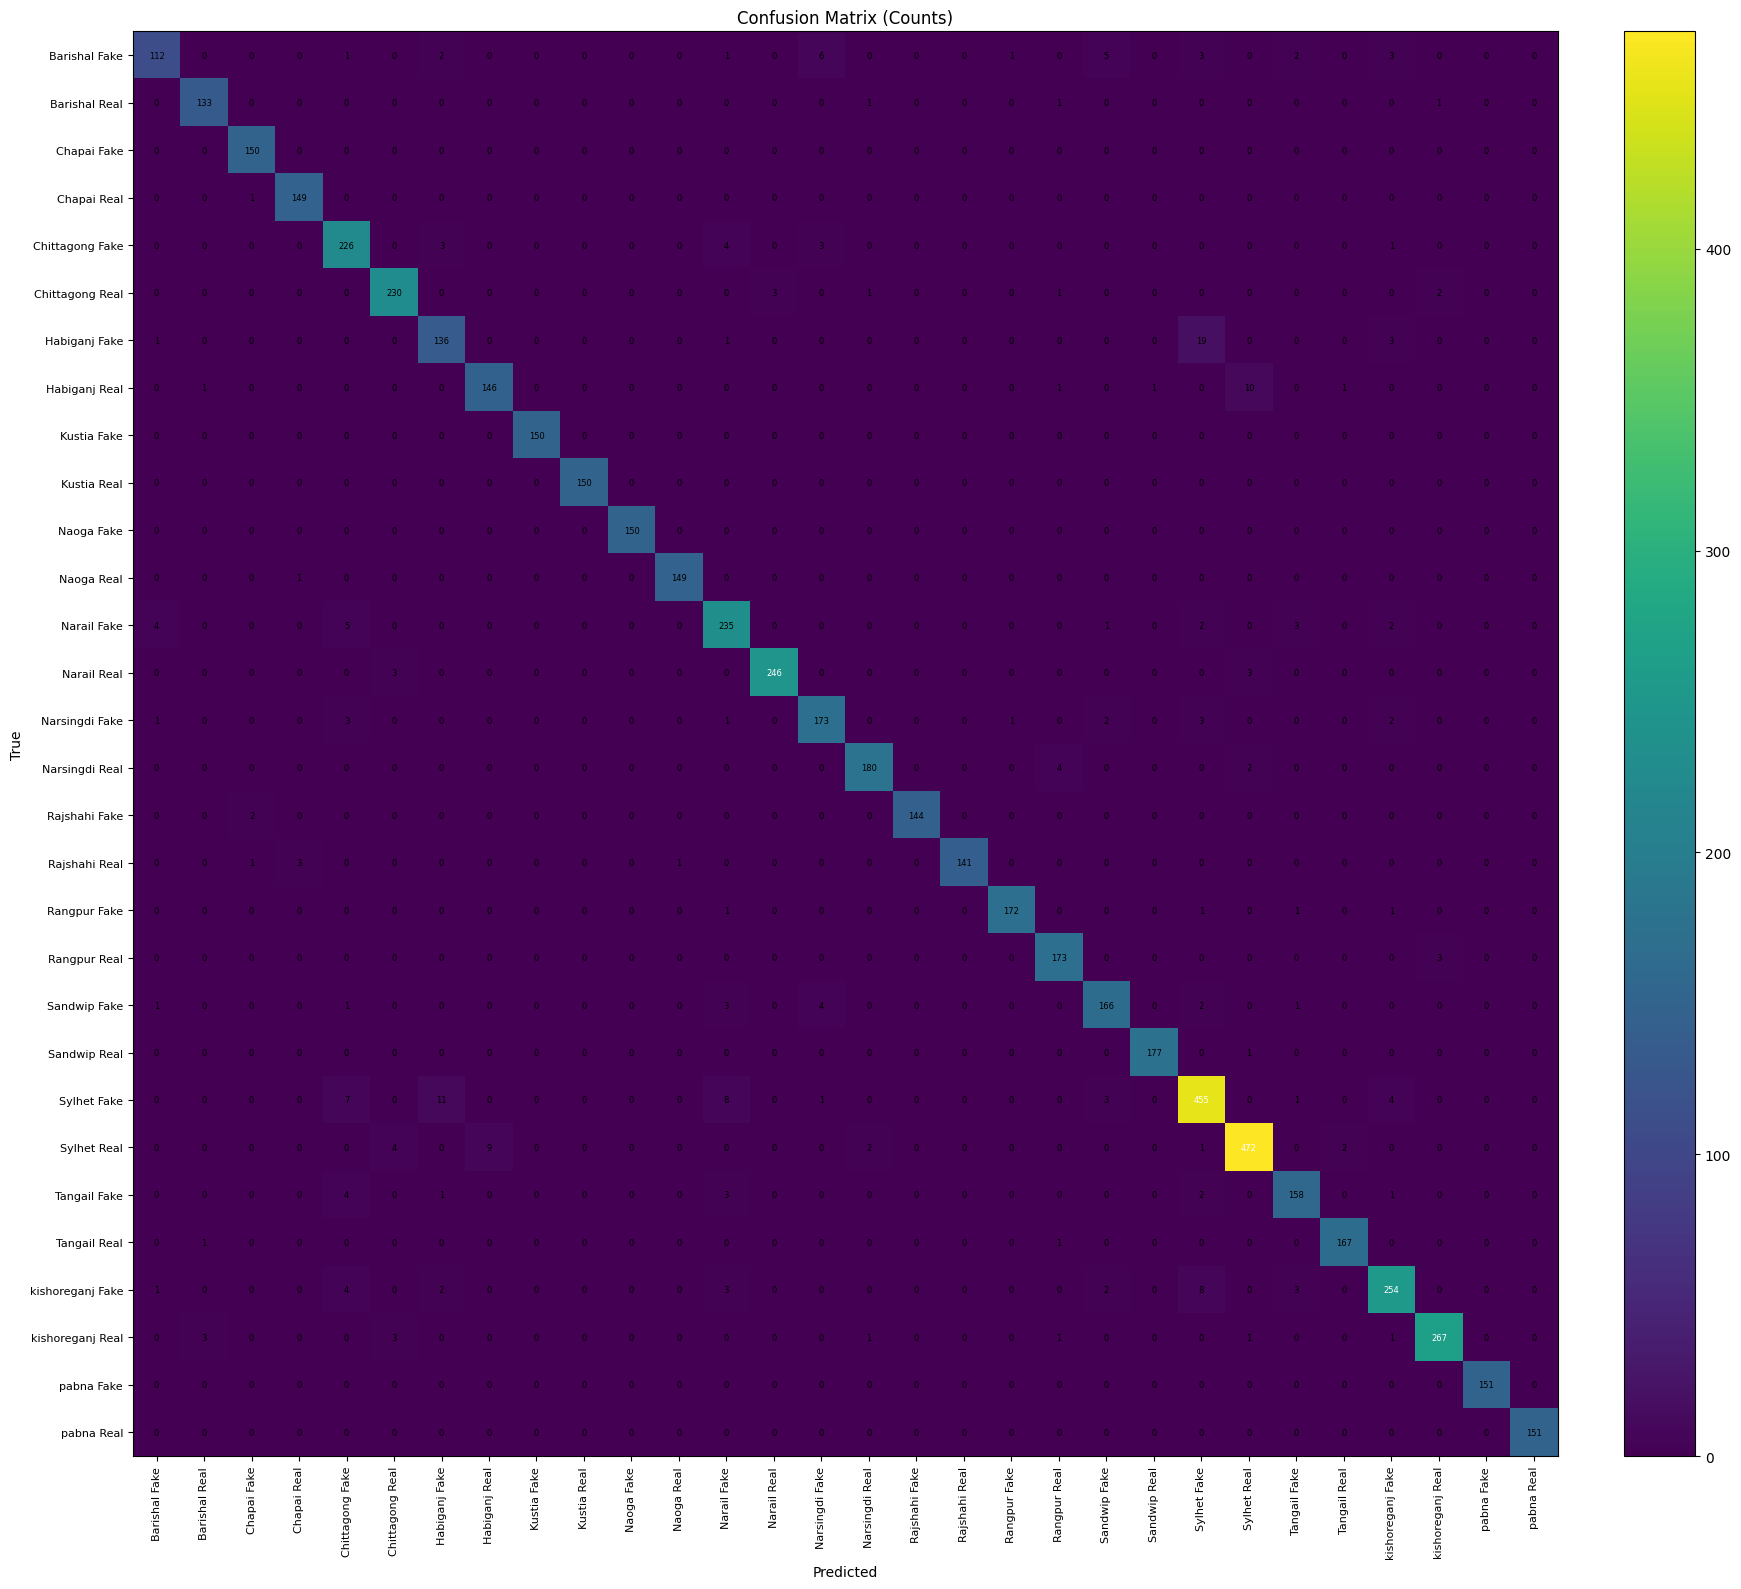

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred, class_names, normalize=None, figsize=(18,16)):
    cm = confusion_matrix(y_true, y_pred)

    if normalize is None:
        cm_show = cm
        fmt = "d"
        title = "Confusion Matrix (Counts)"
    else:
        cm_show = cm.astype(np.float64)
        if normalize == "true":   # row-wise
            cm_show = cm_show / (cm_show.sum(axis=1, keepdims=True) + 1e-12)
            title = "Confusion Matrix (Row-wise Normalized)"
        else:
            raise ValueError("normalize supports only None or 'true'")
        fmt = ".2f"

    plt.figure(figsize=figsize)
    im = plt.imshow(cm_show, interpolation="nearest")
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.xticks(np.arange(len(class_names)), class_names, rotation=90, fontsize=8)
    plt.yticks(np.arange(len(class_names)), class_names, fontsize=8)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    thresh = (cm_show.max() + cm_show.min()) / 2.0
    for i in range(cm_show.shape[0]):
        for j in range(cm_show.shape[1]):
            val = cm_show[i, j]
            plt.text(
                j, i, format(val, fmt),
                ha="center", va="center",
                fontsize=6,
                color="white" if val > thresh else "black"
            )

    plt.tight_layout()
    plt.show()

# শুধু show (counts)
show_confusion_matrix(y_true, y_pred, CLASS_NAMES, normalize=None)

# চাইলে normalized (row-wise %) দেখাও
# show_confusion_matrix(y_true, y_pred, CLASS_NAMES, normalize="true")


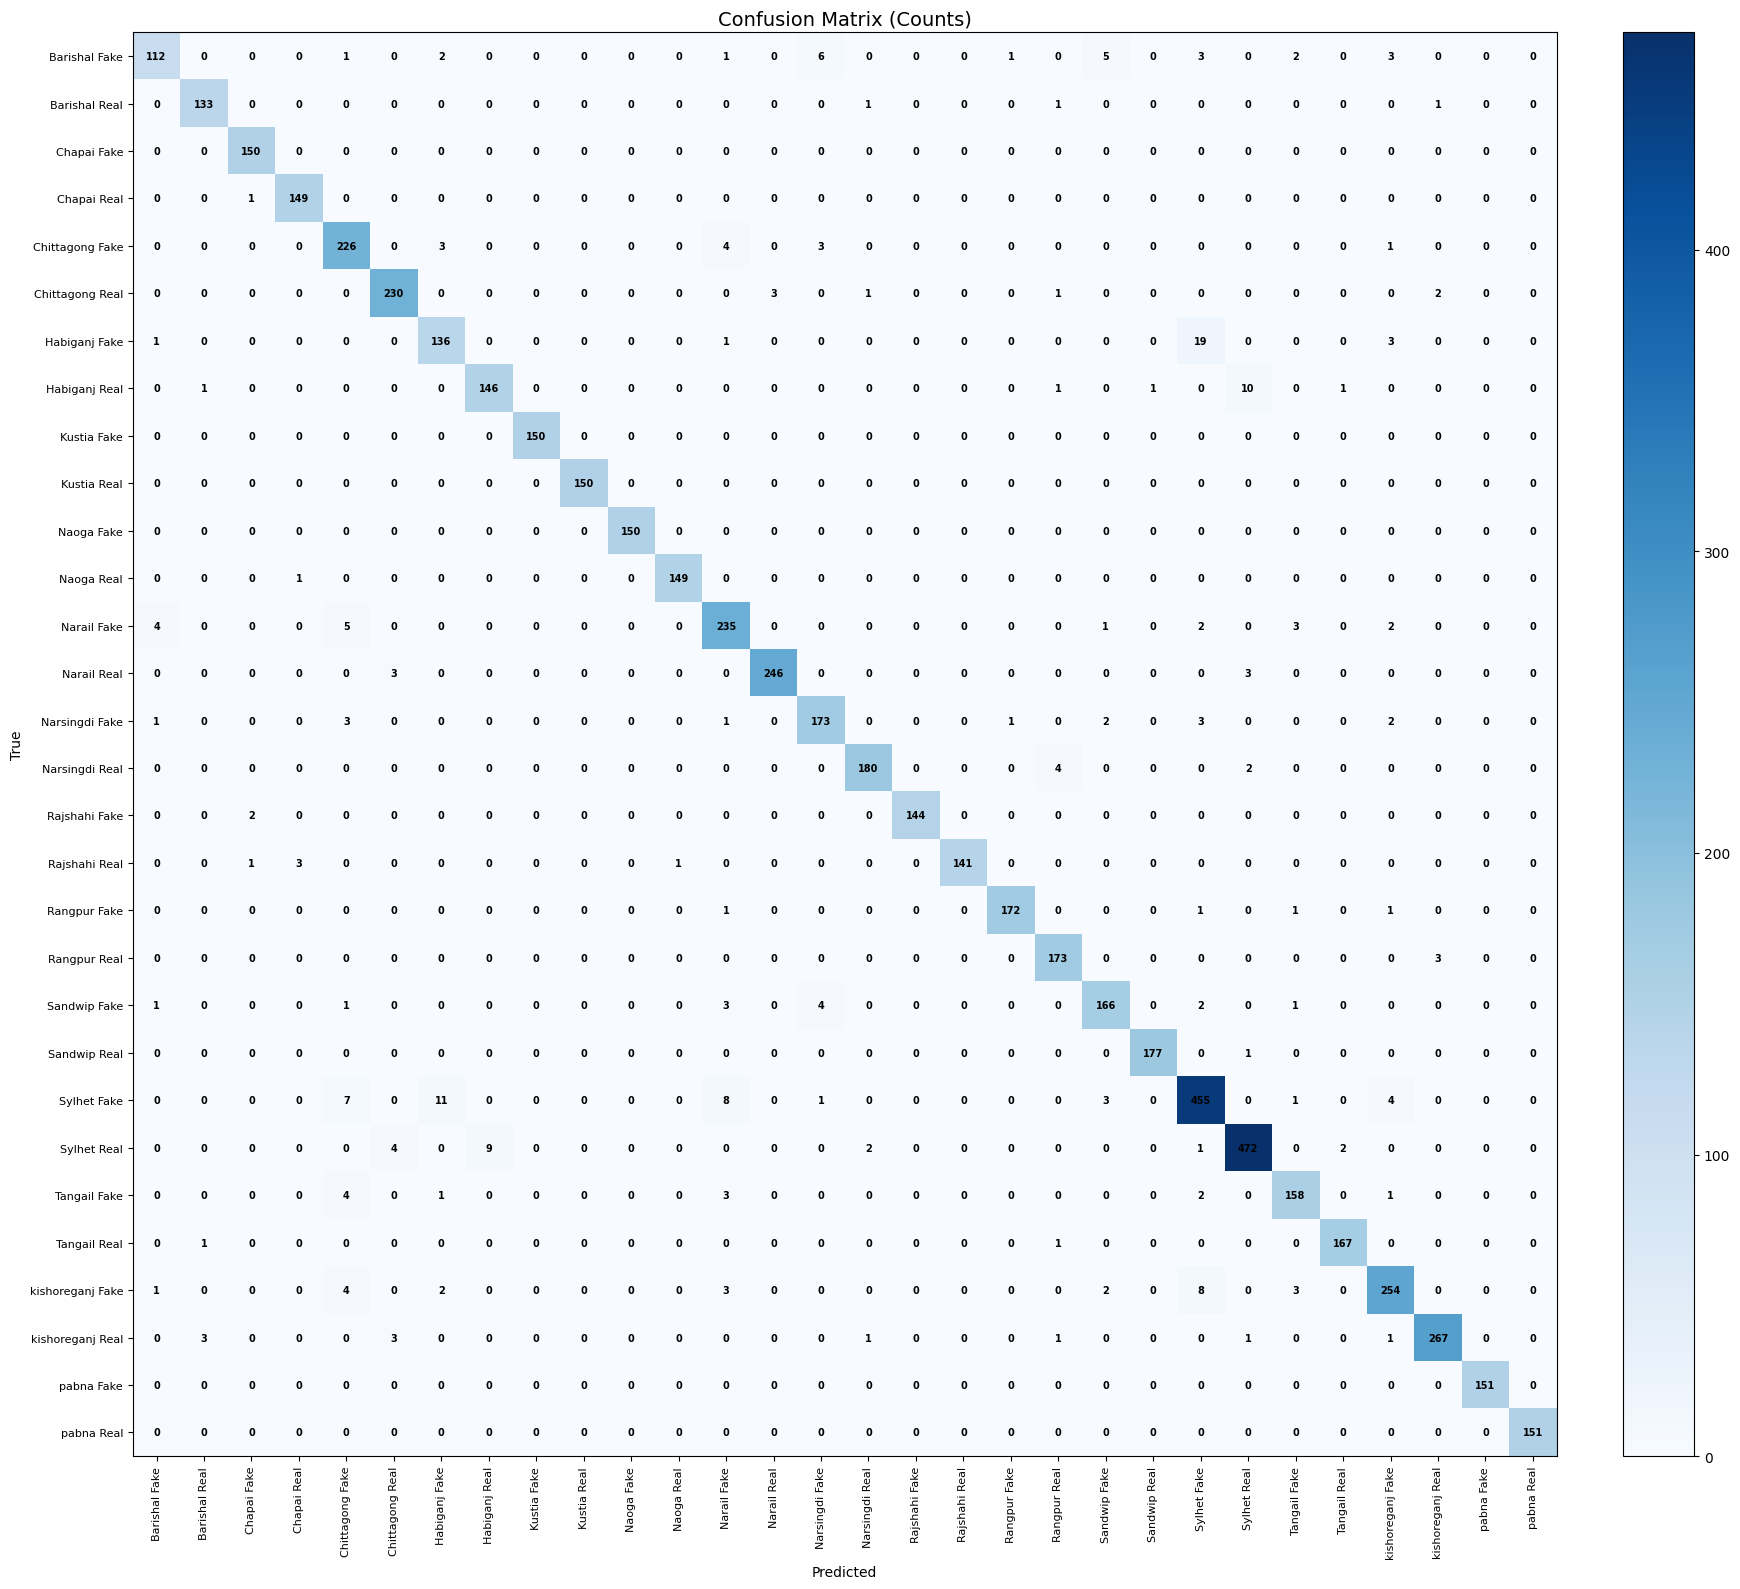

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(
    y_true, y_pred, class_names,
    normalize=None,
    figsize=(18,16)
):
    cm = confusion_matrix(y_true, y_pred)

    if normalize is None:
        cm_show = cm
        fmt = "d"
        title = "Confusion Matrix (Counts)"
    else:
        cm_show = cm.astype(np.float64)
        if normalize == "true":
            cm_show = cm_show / (cm_show.sum(axis=1, keepdims=True) + 1e-12)
            title = "Confusion Matrix (Row-wise Normalized)"
        else:
            raise ValueError("normalize supports only None or 'true'")
        fmt = ".2f"

    plt.figure(figsize=figsize)

    # 🔵 White → Blue colormap
    im = plt.imshow(cm_show, cmap="Blues", interpolation="nearest")
    plt.title(title, fontsize=14)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.xticks(np.arange(len(class_names)), class_names, rotation=90, fontsize=8)
    plt.yticks(np.arange(len(class_names)), class_names, fontsize=8)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # 🔢 Black + Bold numbers
    for i in range(cm_show.shape[0]):
        for j in range(cm_show.shape[1]):
            plt.text(
                j, i, format(cm_show[i, j], fmt),
                ha="center", va="center",
                color="black",
                fontsize=7,
                fontweight="bold"
            )

    plt.tight_layout()
    plt.show()

# শুধু show (counts)
show_confusion_matrix(y_true, y_pred, CLASS_NAMES)

# চাইলে normalized version
# show_confusion_matrix(y_true, y_pred, CLASS_NAMES, normalize="true")


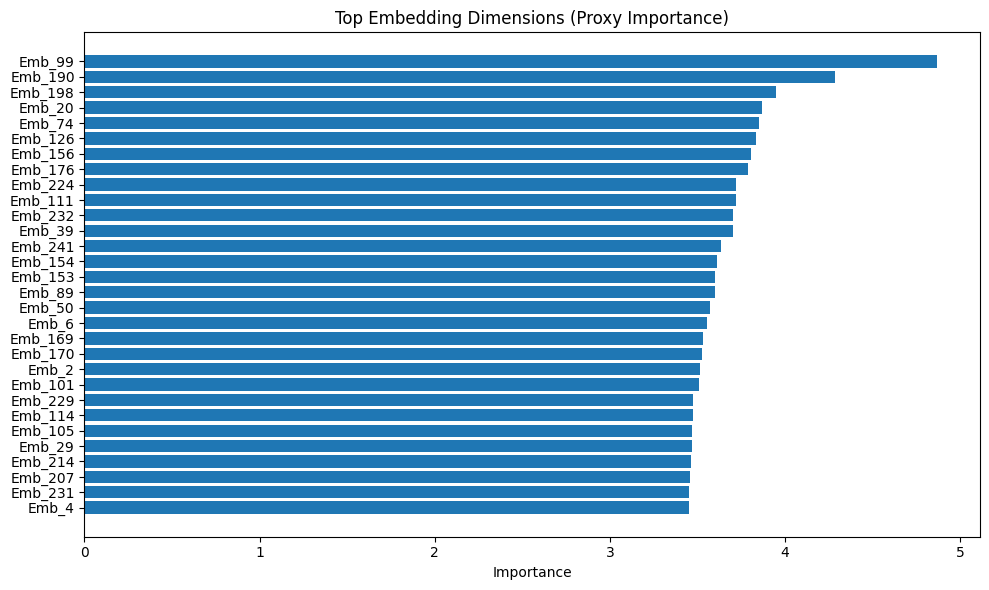

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# embs: (N, 256) already computed
imp = np.mean(np.abs(embs - embs.mean(axis=0, keepdims=True)), axis=0)  # simple importance proxy
topk = 30
idx = np.argsort(imp)[::-1][:topk]

plt.figure(figsize=(10,6))
plt.barh([f"Emb_{i}" for i in idx][::-1], imp[idx][::-1])
plt.title("Top Embedding Dimensions (Proxy Importance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\acer\AppData\Local\Temp\ipykernel_24612\1784532572.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xte[:300], show=True)


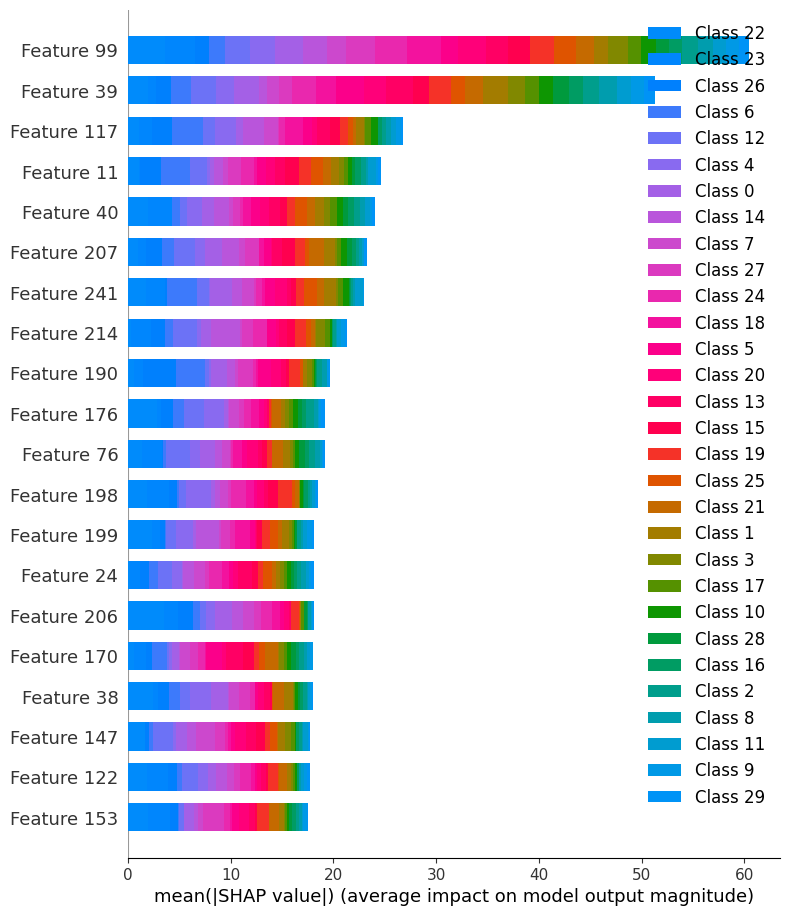

C:\Users\acer\AppData\Local\Temp\ipykernel_24612\1784532572.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xte[:300], plot_type="bar", show=True)


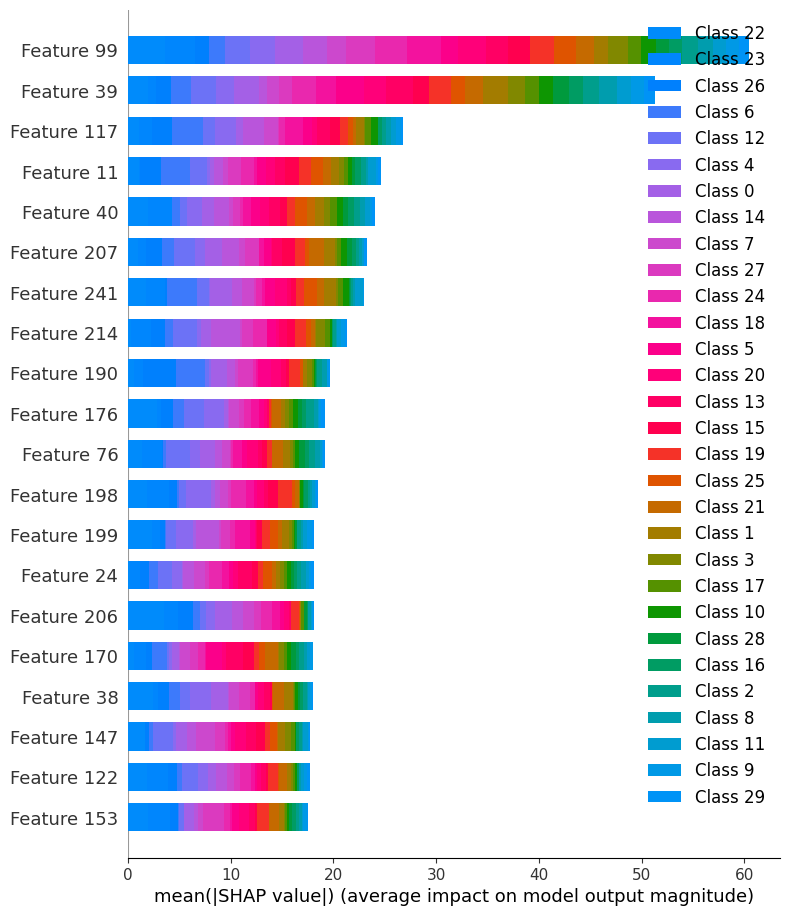

In [5]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = embs
y = emb_labels

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="ovr")
clf.fit(Xtr, ytr)

explainer = shap.Explainer(clf, Xtr[:200])   # background
sv = explainer(Xte[:300])                   # explain a subset

# (a) Beeswarm summary (like your left figure)
shap.summary_plot(sv, Xte[:300], show=True)

# (b) Mean |SHAP| bar (like your right figure)
shap.summary_plot(sv, Xte[:300], plot_type="bar", show=True)


In [6]:
import shap
import numpy as np

# embs: (N,256)
# emb_labels: (N,)
# clf: trained classifier on embeddings

explainer = shap.Explainer(clf, embs[:200])
shap_values = explainer(embs[:300])

# shap_values.values shape:
# (samples, features, classes)
print(shap_values.values.shape)


(300, 256, 30)


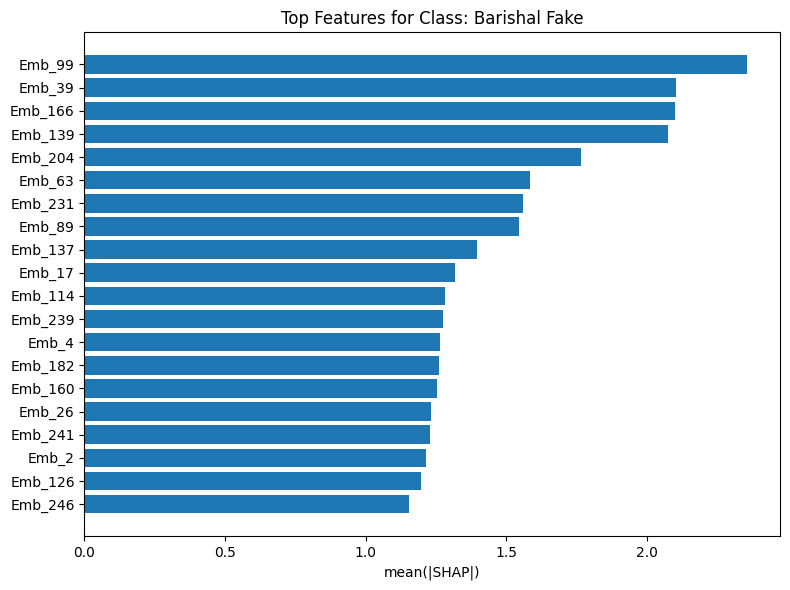

In [7]:
import matplotlib.pyplot as plt

class_id = 0   # e.g., Barishal Fake

mean_shap = np.mean(
    np.abs(shap_values.values[:, :, class_id]),
    axis=0
)

idx = np.argsort(mean_shap)[-20:]

plt.figure(figsize=(8,6))
plt.barh([f"Emb_{i}" for i in idx], mean_shap[idx])
plt.title(f"Top Features for Class: {CLASS_NAMES[class_id]}")
plt.xlabel("mean(|SHAP|)")
plt.tight_layout()
plt.show()


In [8]:
mean_shap_all = np.mean(np.abs(shap_values.values), axis=0)  
# shape: (features, classes)


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\acer\AppData\Local\Temp\ipykernel_24612\3457346084.py:43: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


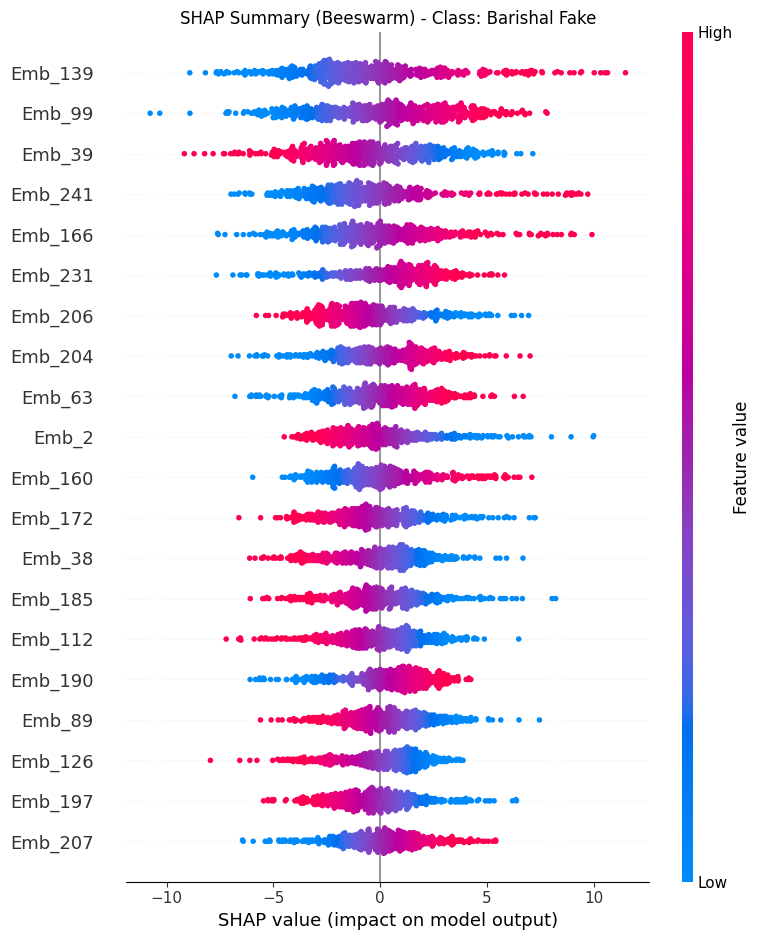

In [9]:
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 1) X=embeddings, y=labels (already computed in your code)
X = embs.astype(np.float32)         # (N,256)
y = emb_labels.astype(int)          # (N,)

# 2) Train a light classifier on embeddings (fast, no audio re-run)
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
clf = LogisticRegression(max_iter=3000, n_jobs=-1, multi_class="ovr")
clf.fit(Xtr, ytr)

# 3) SHAP explainer (background small subset)
bg = Xtr[np.random.choice(len(Xtr), size=min(200, len(Xtr)), replace=False)]
explainer = shap.Explainer(clf, bg)

# 4) Explain a subset for plotting (keep it moderate for speed)
Xplot = Xte[:600]
sv = explainer(Xplot)  # sv.values shape: (samples, features, classes)

# 5) To make Fig(a)-style like paper, pick ONE class or average over classes
#    (a) One class (e.g., class 0)
class_id = 0  # change 0..29
sv_class = sv.values[:, :, class_id]   # (samples, features)

# Top-K features for nicer plot
mean_abs = np.mean(np.abs(sv_class), axis=0)
topk = 20
idx = np.argsort(mean_abs)[-topk:]

feature_names = [f"Emb_{i}" for i in range(X.shape[1])]
Xplot_top = Xplot[:, idx]
sv_top = sv_class[:, idx]
feat_top_names = [feature_names[i] for i in idx]

# 6) FIG (a) - beeswarm / summary plot (very similar to your image)
plt.figure(figsize=(8, 6))
shap.summary_plot(
    sv_top,
    Xplot_top,
    feature_names=feat_top_names,
    show=False
)
plt.title(f"SHAP Summary (Beeswarm) - Class: {CLASS_NAMES[class_id]}")
plt.tight_layout()
plt.show()
